In [1]:
import time
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns 
import lightgbm as lgb
from itertools import cycle
from sklearn.svm import SVR
import statsmodels.api as sm
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

%matplotlib inline 
plt.style.use('bmh')
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Load Data
Data are from the kaggle competition [M5 Forecasting - Accuracy](https://www.kaggle.com/c/m5-forecasting-accuracy).

The task is to forecast, as precisely as possible, the unit sales (demand) of various products sold in the USA by Walmart.

More precisely, we have to forecast daily sales for the next 28 days. The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details.

The data is enormous, and for this demonstration I will use a subset of them, a product from the dataset with a lot of sales.

Our goal is to compare classical time series analysis techniques with machine learning algorithms.

Who will predict better the future?

Competitors:
1. Simple Exponential Smoothing
2. Double Exponential Smoothing
3. Triple Exponential Smoothing
4. ARIMA
5. SARIMA
6. SARIMAX
7. Light Gradient Boosting
8. Random Forest
9. Linear Regression

Make your bet!

In [2]:
data = pd.read_csv('data_for_tsa.csv')
data['date'] = pd.to_datetime(data['date'])
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,date,sell_price,year,month,dayofweek
0,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,98,2011-01-29,1.48,2011,1,5
1,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,85,2011-01-30,1.48,2011,1,6
2,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,47,2011-01-31,1.48,2011,1,0
3,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,56,2011-02-01,1.48,2011,2,1
4,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,51,2011-02-02,1.48,2011,2,2


The **target** variable to predict is the **demand** (how many items of this product will be sold on that date).

Dates are from 2011-01-29 to 2016-05-22, totaling 1941 days. The last 28 days are the competition_test set, as instructed by the competition, so we don't know the demand (it is equal to 0).

In order to train and validate the models i will split the data into two parts: train and test. The test set shall not be confused with the competition_test set.

The **test set** will have the same length as the test competition_test to simulate the same conditions. So it will consist of the dates between **2016-03-27 and 2016-04-24 (28 days)**. The train set will be all the other previous values.

In [3]:
train = data[data['date'] <= '2016-03-27']
test = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]

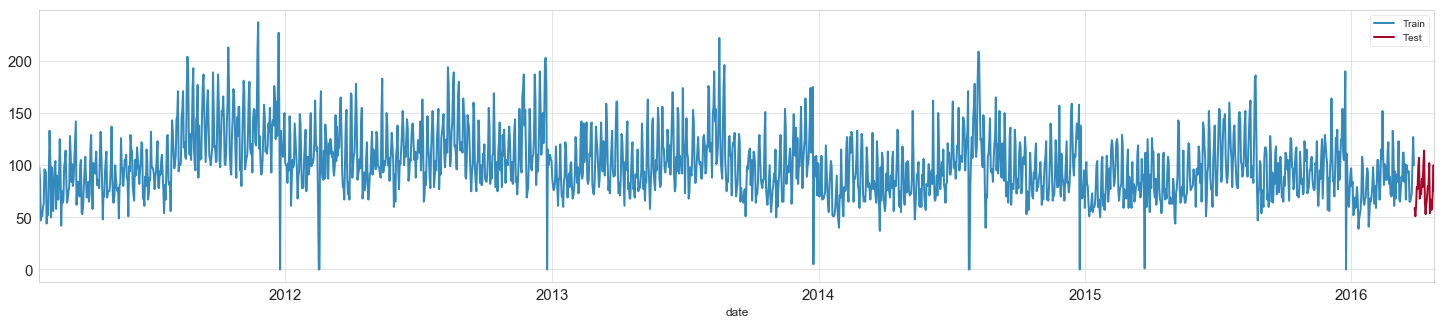

In [4]:
fig, ax = plt.subplots(figsize=(25,5))
train.plot(x='date',y='demand',label='Train',ax=ax)
test.plot(x='date',y='demand',label='Test',ax=ax);

We have a lot of training data and the last 28 days are the test set. Our goal is to predict them using the previous values.

Next, I will create a *predictions* dataframe to store the predictions of all models. Each model will be a column in this dataframe. Also, a *stats* dataframe to store the performance and execution time of each model.

In [5]:
predictions = pd.DataFrame()
predictions['date'] = test['date']
stats = pd.DataFrame(columns=['Model Name','Execution Time','RMSE'])

## Train and Evaluate Models

We will begin with the simple traditional forecasting models. Don't underestimate them.

### Simple Exponential Smoothing
This is a variation of the Simple Moving Average called Exponentially Weighted Moving Average (EWMA) or Simple Holt-Winters method. The package that is used to load it to Python is called SimpleExpSmoothing. We have to define a parameter called *span*, which will be equal to the seasonal periods of the dataset.

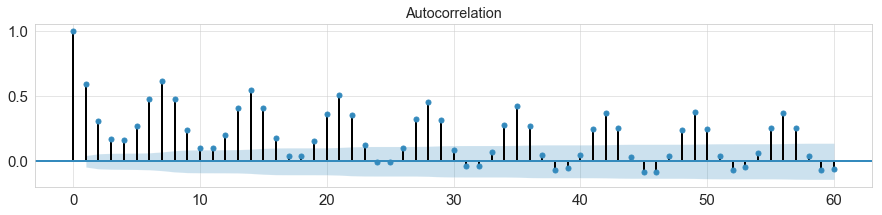

In [6]:
fig, ax = plt.subplots(figsize=(15, 3))
plot_acf(data['demand'].tolist(), lags=60, ax=ax);

From the autocorrelation plot we can clearly see that every 7 lags there is a peak in correlation. This means that the value of the present day and the value of 7 days earlier have high correlation. I will set span equal to 7. After training, using *.forecast(x)*, with x=28 days, the model predicts the next 28 days. The evaluation will be made with Root Mean Square Error.

RMSE for Simple Exponential Smoothing: 25.9010


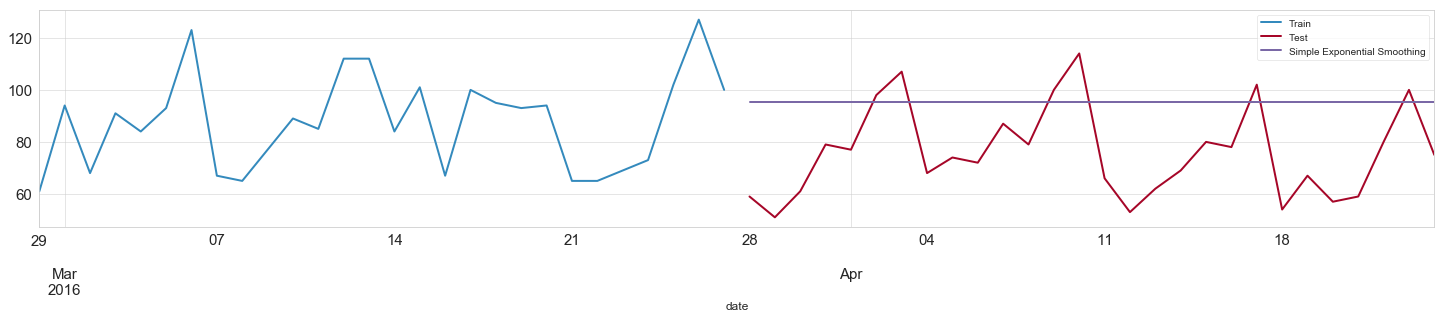

In [9]:
t0 = time.time()
model_name='Simple Exponential Smoothing'
span = 7
alpha = 2/(span+1)
#train
simpleExpSmooth_model = SimpleExpSmoothing(train['demand']).fit(smoothing_level=alpha,optimized=False)
t1 = time.time()-t0
#predict
predictions[model_name] = simpleExpSmooth_model.forecast(28).values
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='date',y='demand',label='Train',ax=ax)
test.plot(x='date',y='demand',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['demand']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

Those who voted for Simple Exponential Smoothing will indeed be disappointed. Nevertheless, let's keep its RMSE as baseline.

## Double Exponential Smoothing
Where Simple Exponential Smoothing employs just one smoothing factor α (alpha), Double Exponential Smoothing adds a second smoothing factor β (beta) that addresses trends in the data. We have to define *seasonal_periods*.

RMSE for Double Exponential Smoothing: 22.6501


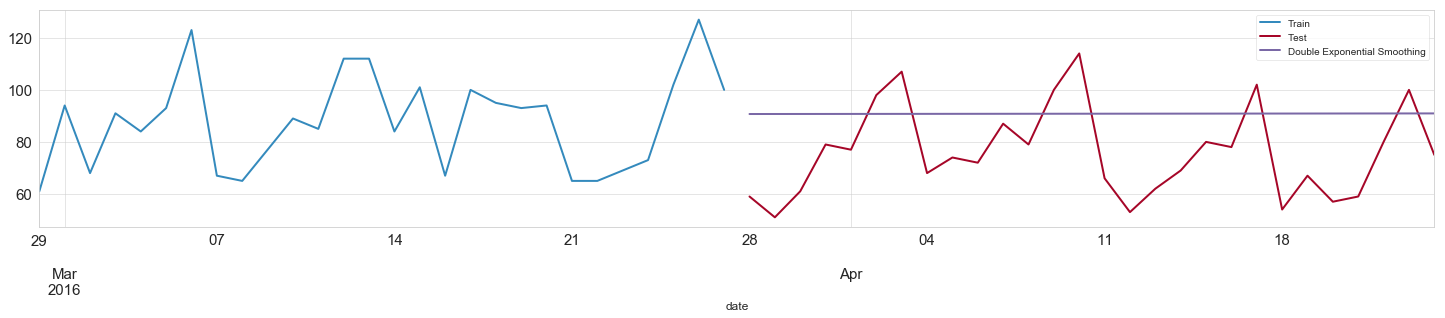

In [9]:
t0 = time.time()
model_name='Double Exponential Smoothing'
#train
doubleExpSmooth_model = ExponentialSmoothing(train['demand'],trend='add',seasonal_periods=7).fit()
t1 = time.time()-t0
#predict
predictions[model_name] = doubleExpSmooth_model.forecast(28).values
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='date',y='demand',label='Train',ax=ax)
test.plot(x='date',y='demand',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['demand']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

Better than SES, but it is still a straight line. Can we do better?

## Triple Exponential Smoothing
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data.

RMSE for Triple Exponential Smoothing: 14.8771


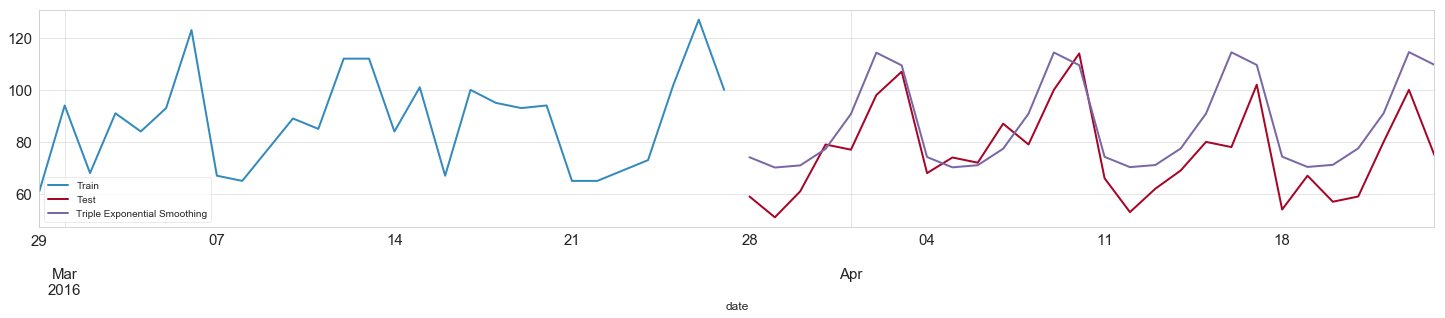

In [10]:
t0 = time.time()
model_name='Triple Exponential Smoothing'
#train
tripleExpSmooth_model = ExponentialSmoothing(train['demand'],trend='add',seasonal='add',seasonal_periods=7).fit()
t1 = time.time()-t0
#predict
predictions[model_name] = tripleExpSmooth_model.forecast(28).values
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='date',y='demand',label='Train',ax=ax)
test.plot(x='date',y='demand',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['demand']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

Now we are doing something! TES captures the seasonality of the data nicely and is almost constantly close to the test data. The drawback is that we have to enter the number of the seasonal periods. If this number is different than 7, the performance worsens.

## ARIMA
An ARIMA model is characterized by 3 components: p, d, q

- p is the order of the AR term. It refers to the number of lags of Y to be used as predictors.
- q is the order of the MA term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.
- d is the number of differencing required to make the time series stationary

**Automatically select ARIMA parameters**

We will use the excellent *auto_arima* package, which automatically discovers the optimal order for an ARIMA model.

Let's ignore the seasonality. If we add seasonality the model will be SARIMA, which will be discussed later.

In [11]:
t0 = time.time()
model_name='ARIMA'
arima_model = auto_arima(train['demand'], start_p=0, start_q=0,
                          max_p=14, max_q=3,
                          seasonal=False,
                          d=None, trace=True,random_state=2020,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
arima_model.summary() 

Fit ARIMA: order=(0, 1, 0); AIC=18145.383, BIC=18156.466, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=18102.507, BIC=18119.131, Fit time=0.049 seconds
Fit ARIMA: order=(0, 1, 1); AIC=17856.372, BIC=17872.996, Fit time=0.141 seconds
Fit ARIMA: order=(1, 1, 1); AIC=17566.074, BIC=17588.239, Fit time=0.390 seconds
Fit ARIMA: order=(1, 1, 2); AIC=17522.511, BIC=17550.217, Fit time=0.573 seconds
Fit ARIMA: order=(2, 1, 3); AIC=16970.620, BIC=17009.408, Fit time=2.442 seconds
Fit ARIMA: order=(1, 1, 3); AIC=17511.030, BIC=17544.277, Fit time=0.862 seconds
Fit ARIMA: order=(3, 1, 3); AIC=16935.927, BIC=16980.256, Fit time=4.966 seconds
Fit ARIMA: order=(3, 1, 2); AIC=17330.858, BIC=17369.646, Fit time=0.651 seconds
Fit ARIMA: order=(2, 1, 2); AIC=17383.335, BIC=17416.582, Fit time=0.612 seconds
Fit ARIMA: order=(4, 1, 3); AIC=16931.746, BIC=16981.616, Fit time=7.689 seconds
Fit ARIMA: order=(4, 1, 2); AIC=17162.693, BIC=17207.023, Fit time=2.296 seconds
Fit ARIMA: order=(5, 1, 3); 

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1884
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -8452.904
Method:                       css-mle   S.D. of innovations             21.462
Date:                Fri, 10 Apr 2020   AIC                          16925.807
Time:                        17:56:51   BIC                          16981.219
Sample:                             1   HQIC                         16946.215
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.064      0.131      0.896      -0.117       0.134
ar.L1.D.y      1.4460      0.030     48.671      0.000       1.388       1.504
ar.L2.D.y     -1.2996      0.036    -36.250      0.000      -1.370      -1.229
ar.L3.D.y      0.3511      0.046      7.672      0.000       0.261       0.441
ar.L4.D.y     -0.1603      0.040     -3.978      0.000      -0.239      -0.081
ar.L5.D.y      0.0872      0.030      2.941      0.003       0.029       0.145
ma.L1.D.y     -2.1292      0.022    -94.678      0.000      -2.173      -2.085
ma.L2.D.y      2.0780      0.033     63.315      0.000       2.014       2.142
ma.L3.D.y     -0.8744      0.022    -39.254      0.000      -0.918      -0.831
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6237           -0.7822j            1.0004           -0.1429
AR.2            0.6237           +0.7822j            1.0004            0.1429
AR.3            2.0994           -0.0000j            2.0994           -0.0000
AR.4           -0.7546           -2.2106j            2.3358           -0.3024
AR.5           -0.7546           +2.2106j            2.3358            0.3024
MA.1            0.6325           -0.7930j            1.0144           -0.1428
MA.2            0.6325           +0.7930j            1.0144            0.1428
MA.3            1.1114           -0.0000j            1.1114           -0.0000
-----------------------------------------------------------------------------
"""

RMSE for ARIMA: 17.2683


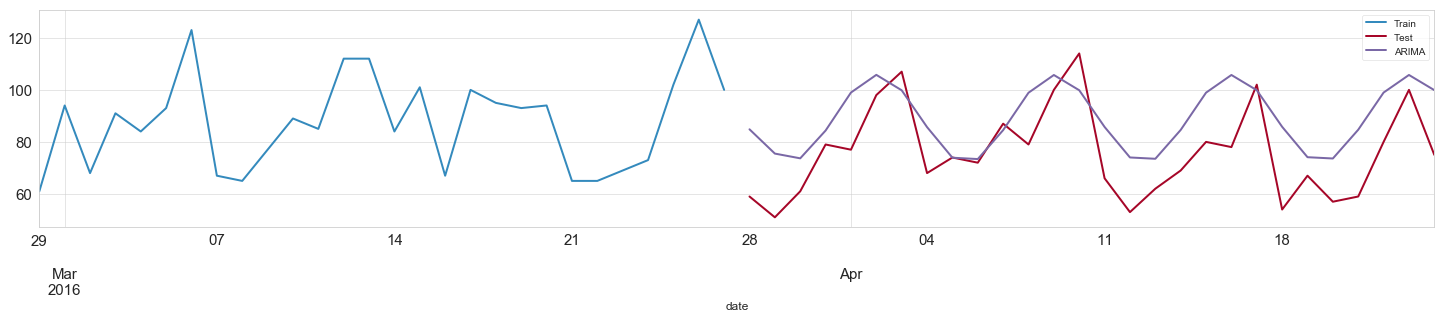

In [12]:
#train
arima_model.fit(train['demand'])
t1 = time.time()-t0
#predict
predictions[model_name] = arima_model.predict(n_periods=28)
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='date',y='demand',label='Train',ax=ax)
test.plot(x='date',y='demand',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['demand']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

The simple ARIMA model used here does not account for seasonality. It was a (5,1,3) model. This means that it uses 5 lags to predict the current value. The size of the moving window which is referring to the number of lagged forecast errors is equal to 1. The differencing required to make the time series stationary is 3.

This model performs worse than the Triple Exponential Smoothing.

## SARIMA
It is an extension of ARIMA that accepts an additional set of parameters that specifically describe the seasonal components of the model.

We will use 2 extra parameters compared to ARIMA: *seasonal=True* and *m=7*. We now account for seasonality and say to the model that it is equal to 7. Auto_arima runs for a much longer period.

In [13]:
t0 = time.time()
model_name='SARIMA'
sarima_model = auto_arima(train['demand'], start_p=0, start_q=0,
                          max_p=14, max_q=3,
                          seasonal=True, m=7,
                          d=None, trace=True,random_state=2020,
                          out_of_sample_size=28,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
sarima_model.summary() 

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 7); AIC=17431.825, BIC=17453.989, Fit time=4.164 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=18145.383, BIC=18156.466, Fit time=0.122 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=17741.410, BIC=17763.575, Fit time=1.192 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=17571.663, BIC=17593.827, Fit time=1.583 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 7); AIC=17986.384, BIC=18003.007, Fit time=0.934 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 1, 7); AIC=17432.228, BIC=17459.933, Fit time=7.136 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=17905.660, BIC=17922.284, Fit time=0.646 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 2, 7); AIC=17432.139, BIC=17459.845, Fit time=6.685 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 2, 7); AIC=17434.104, BIC=17467.351, Fit time=7.098 seconds
Fit ARIMA: order=(1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1885
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -8375.319
Date:                           Fri, 10 Apr 2020   AIC                          16766.637
Time:                                   17:59:50   BIC                          16810.966
Sample:                                        0   HQIC                         16782.963
                                          - 1885                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.003      0.113      0.910      -0.005       0.006
ar.L1          0.2393      0.021     11.418      0.000       0.198       0.280
ar.L2          0.0129      0.023      0.572      0.567      -0.031       0.057
ar.L3         -0.0225      0.023     -0.964      0.335      -0.068       0.023
ma.L1         -0.8912      0.017    -51.603      0.000      -0.925      -0.857
ar.S.L7        0.9960      0.002    559.297      0.000       0.993       1.000
ma.S.L7       -0.9486      0.011    -87.765      0.000      -0.970      -0.927
sigma2       442.8586      8.106     54.630      0.000     426.970     458.747
===================================================================================
Ljung-Box (Q):                       50.88   Jarque-Bera (JB):              6528.13
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                            -1.02
Prob(H) (two-sided):                  0.32   Kurtosis:                        11.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE for SARIMA: 14.4320


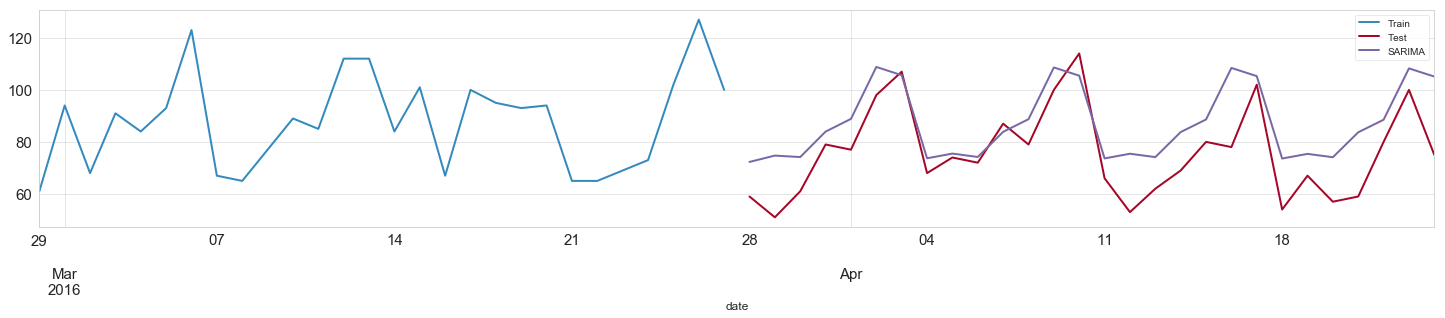

In [14]:
#train
sarima_model.fit(train['demand'])
t1 = time.time()-t0
#predict
predictions[model_name] = sarima_model.predict(n_periods=28)
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='date',y='demand',label='Train',ax=ax)
test.plot(x='date',y='demand',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['demand']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

This is much better than simple ARIMA, and in fact it is better than Triple Exponential Smoothing!

## SARIMAX
Using the previous approaches the only data we can use are the previous historical data. The Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors introduces the idea that external features can influence a time series.

We will add another feature of the dataset, the *sell_price* to assist the model and hopefully make better predictions.

In [15]:
t0 = time.time()
model_name='SARIMAX'
sarimax_model = auto_arima(train['demand'], start_p=0, start_q=0,
                          max_p=14, max_q=3,
                          seasonal=True, m=7,
                          exogenous = train[['sell_price']].values,
                          d=None, trace=True,random_state=2020,
                          out_of_sample_size=28,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
sarimax_model.summary() 

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 7); AIC=17432.026, BIC=17459.732, Fit time=4.681 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=18147.111, BIC=18163.735, Fit time=0.157 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=17742.000, BIC=17769.706, Fit time=1.379 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=17574.387, BIC=17602.093, Fit time=1.931 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 7); AIC=17987.496, BIC=18009.661, Fit time=1.124 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 1, 7); AIC=17432.025, BIC=17465.272, Fit time=9.592 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 0, 7); AIC=17778.038, BIC=17805.743, Fit time=2.156 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 2, 7); AIC=17433.982, BIC=17472.770, Fit time=10.527 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=17906.312, BIC=17928.476, Fit time=0.757 seconds
Fit ARIMA: order=(

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1885
Model:             SARIMAX(5, 1, 1)x(2, 0, 1, 7)   Log Likelihood               -8378.418
Date:                           Fri, 10 Apr 2020   AIC                          16780.836
Time:                                   18:06:48   BIC                          16847.330
Sample:                                        0   HQIC                         16805.325
                                          - 1885                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.758e-05      0.000      0.130      0.896      -0.001       0.001
x1          -109.9988     27.881     -3.945      0.000    -164.645     -55.353
ar.L1          0.3483      0.014     24.734      0.000       0.321       0.376
ar.L2          0.0760      0.021      3.544      0.000       0.034       0.118
ar.L3          0.0457      0.022      2.061      0.039       0.002       0.089
ar.L4          0.0575      0.024      2.348      0.019       0.010       0.106
ar.L5          0.0922      0.024      3.883      0.000       0.046       0.139
ma.L1         -0.9874      0.005   -213.779      0.000      -0.996      -0.978
ar.S.L7        1.0505      0.027     39.509      0.000       0.998       1.103
ar.S.L14      -0.0547      0.026     -2.105      0.035      -0.106      -0.004
ma.S.L7       -0.9513      0.012    -79.200      0.000      -0.975      -0.928
sigma2       445.9209      8.587     51.927      0.000     429.090     462.752
===================================================================================
Ljung-Box (Q):                       69.03   Jarque-Bera (JB):              5453.87
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.84
Prob(H) (two-sided):                  0.66   Kurtosis:                        11.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE for SARIMAX: 14.3681


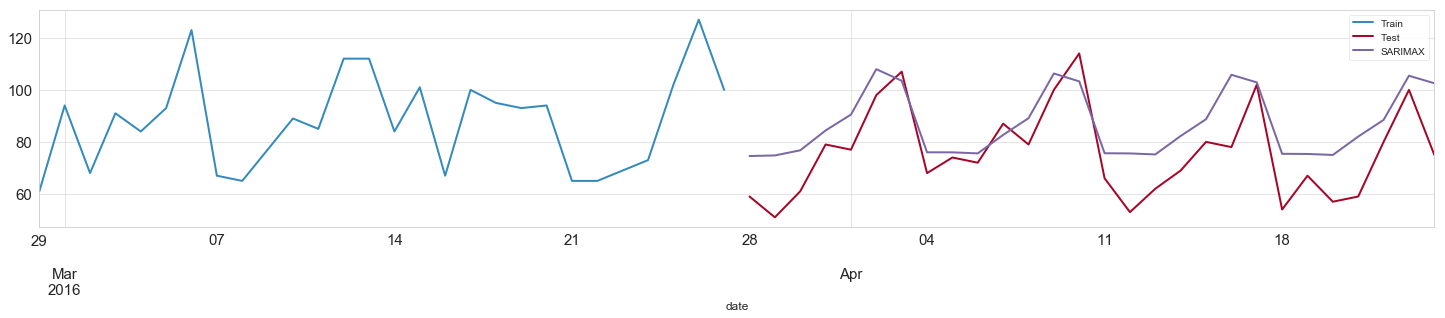

In [16]:
#train
sarimax_model.fit(train['demand'])
t1 = time.time()-t0
#predict
predictions[model_name] = sarimax_model.predict(n_periods=28)
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='date',y='demand',label='Train',ax=ax)
test.plot(x='date',y='demand',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['demand']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

SARIMAX runs for much longer. The extra feature decreases the error!

## Machine Learning
Machine learning models, can not predict the target by just the previous values of itself. They need features. This is what we are going to do, construct some features.

All the information on the previous values of the target is lost. We will create features to maintain that information.

In [17]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,date,sell_price,year,month,dayofweek
0,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,98,2011-01-29,1.48,2011,1,5
1,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,85,2011-01-30,1.48,2011,1,6
2,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,47,2011-01-31,1.48,2011,1,0
3,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,56,2011-02-01,1.48,2011,2,1
4,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,51,2011-02-02,1.48,2011,2,2


The features that I will create are relatively few and simple.
- Lag 7: The demand value 7 days earlier
- Rolling mean 7_7: On the lag 7, compute the rolling mean for the 7 days earlier. That means we are now back in time 14 days.

While lag 7 captures a single day, rolling mean 7 captures information about 7 days in a single feature.

Someone could think, oh so why don't we create a feature for each lag? Lag 1,2,3,..1885,..? We could create some of them like lag 6 and 8 (we saw them being strong in the autocorrelation plot), or lag 14, 30. However increasing the dimensionality of the dataset would be a serious problem. RAM overload, huge execution times, overfitting, correlations.

Other features created include:
- Per month demand mean, max, max_to_min_diff. This captures the information: for this product how much was its mean sales on Decembers, on Aprils etc.
- Per dayofweek mean, median, max

In [44]:
def lags_windows(df):
    lags = [7]
    lag_cols = ["lag_{}".format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","demand"]].groupby("id")["demand"].shift(lag)

    wins = [7]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df["rmean_{}_{}".format(lag,win)] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())   
    return df

def per_timeframe_stats(df, col):
    #For each item compute its mean and other descriptive statistics for each month and dayofweek in the dataset
    months = df['month'].unique().tolist()
    for y in months:
        df.loc[df['month'] == y, col+'_month_mean'] = df.loc[df['month'] == y].groupby(['id'])[col].transform(lambda x: x.shift(1).mean()).astype("float32")
        df.loc[df['month'] == y, col+'_month_max'] = df.loc[df['month'] == y].groupby(['id'])[col].transform(lambda x: x.shift(1).max()).astype("float32")
        df.loc[df['month'] == y, col+'_month_min'] = df.loc[df['month'] == y].groupby(['id'])[col].transform(lambda x: x.shift(1).min()).astype("float32")
        df[col + 'month_max_to_min_diff'] = (df[col + '_month_max'] - df[col + '_month_min']).astype("float32")

    dayofweek = df['dayofweek'].unique().tolist()
    for y in dayofweek:
        df.loc[df['dayofweek'] == y, col+'_dayofweek_mean'] = df.loc[df['dayofweek'] == y].groupby(['id'])[col].transform(lambda x: x.shift(1).mean()).astype("float32")
        df.loc[df['dayofweek'] == y, col+'_dayofweek_median'] = df.loc[df['dayofweek'] == y].groupby(['id'])[col].transform(lambda x: x.shift(1).median()).astype("float32")
        df.loc[df['dayofweek'] == y, col+'_dayofweek_max'] = df.loc[df['dayofweek'] == y].groupby(['id'])[col].transform(lambda x: x.shift(1).max()).astype("float32")
    return df

def feat_eng(df):
    df = lags_windows(df)
    df = per_timeframe_stats(df,'demand')
    return df

In [45]:
data = pd.read_csv('data_for_tsa.csv')
data['date'] = pd.to_datetime(data['date'])
train = data[data['date'] <= '2016-03-27']
test = data[(data['date'] > '2016-03-11') & (data['date'] <= '2016-04-24')]
  
data_ml = feat_eng(train)
data_ml = data_ml.dropna() 

In [46]:
useless_cols = ['id','item_id','dept_id','cat_id','store_id','state_id','demand','date','demand_month_min']
linreg_train_cols = ['sell_price','year','month','dayofweek','lag_7','rmean_7_7'] #use different columns for linear regression
lgb_train_cols = data_ml.columns[~data_ml.columns.isin(useless_cols)]
X_train = data_ml[lgb_train_cols].copy()
y_train = data_ml["demand"]

## Fit Models

In [47]:
#Fit Light Gradient Boosting
t0 = time.time()
lgb_params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        'verbosity': 1,
        'num_iterations' : 2000,
        'num_leaves': 128,
        "min_data_in_leaf": 50,
}
np.random.seed(777)
fake_valid_inds = np.random.choice(X_train.index.values, 365, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)
train_data = lgb.Dataset(X_train.loc[train_inds] , label = y_train.loc[train_inds], free_raw_data=False)
fake_valid_data = lgb.Dataset(X_train.loc[fake_valid_inds], label = y_train.loc[fake_valid_inds],free_raw_data=False)

m_lgb = lgb.train(lgb_params, train_data, valid_sets = [fake_valid_data], verbose_eval=0) 
t_lgb = time.time()-t0

#Fit Linear Regression
t0 = time.time()
m_linreg = LinearRegression().fit(X_train[linreg_train_cols].loc[train_inds], y_train.loc[train_inds])
t_linreg = time.time()-t0

#Fit Random Forest
t0 = time.time()
m_rf = RandomForestRegressor(n_estimators=100,max_depth=5, random_state=26, n_jobs=-1).fit(X_train.loc[train_inds], y_train.loc[train_inds])
t_rf = time.time()-t0

## Predict with Models using a sliding window

This part requires more attention. I will explain.

The test set consists of 28 days. Let's say day 1,2,3...,28. Remember the feature lag_7 that we created for the train set? We will create the same feature for the test set obviously. When we create this feature for the 1st day of the test set, it is created just great. It goes 7 days earlier (in the train set) and copies this value. If we create this feature for the 10th day, it goes 7 days earlier. This is the 3rd day in the test set. We don't know its value!

So we do a sliding window and move it one day ahead at a time. In each iteration, we predict today's value. So we fill the test set with our predictions. When we reach day 10 in the test set we will have the previous values and can compute the lag7.

Wait, why you use a sliding window of length 15 (max_lags=15)? The feature lag 7 needs samples at least 7 days earlier. The feature rolling mean 7_7 needs 14 days earlier. So the minimum window size would be 14 in order to successfully create the features. If we increase the size of the window it will not affect these features. They don't use earlier values. But if we increase it, then it will affect the other features (Per month demand mean etc). I have tried to increase it and what it does is a little decrease in the rmse and a bigger increase in the execution time.

In [52]:
fday = datetime(2016,3, 28) 
max_lags = 15
for tdelta in range(0, 28):
    day = fday + timedelta(days=tdelta)
    tst = test[(test.date >= day - timedelta(days=max_lags)) & (test.date <= day)].copy()
    tst = feat_eng(tst)
    tst_lgb = tst.loc[tst.date == day , lgb_train_cols].copy()
    test.loc[test.date == day, "preds_LightGB"] = m_lgb.predict(tst_lgb)
    tst_rf = tst.loc[tst.date == day , lgb_train_cols].copy()
    tst_rf = tst_rf.fillna(0) 
    test.loc[test.date == day, "preds_RandomForest"] = m_rf.predict(tst_rf)
    
    tst_linreg = tst.loc[tst.date == day , linreg_train_cols].copy()
    tst_linreg = tst_linreg.fillna(0)    
    test.loc[test.date == day, "preds_LinearReg"] = m_linreg.predict(tst_linreg) 
    
test_final = test.loc[test.date >= fday]

## Light Gradient Boosting
I tuned the parameters of the algorithm for better performance.

RMSE for LightGB: 10.3920


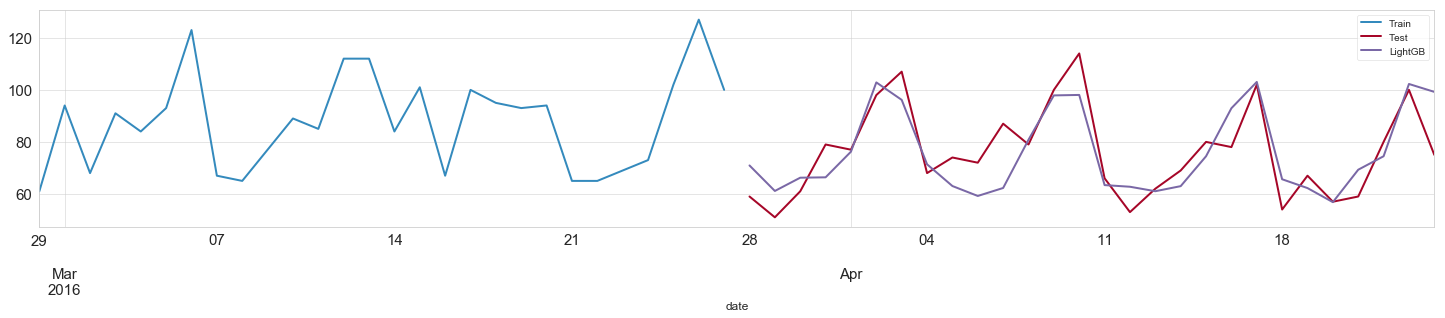

In [53]:
model_name='LightGB'
predictions[model_name] = test_final["preds_"+model_name]

#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='date',y='demand',label='Train',ax=ax)
test_final.plot(x='date',y='demand',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test_final['demand']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t_lgb, 'RMSE':score},ignore_index=True)

Ah LightGB.. It never disappoints. (however don't use it in every problem blindlessly)

## Random Forest
I tuned the maximum depth of the tree for better performance.

RMSE for RandomForest: 10.9834


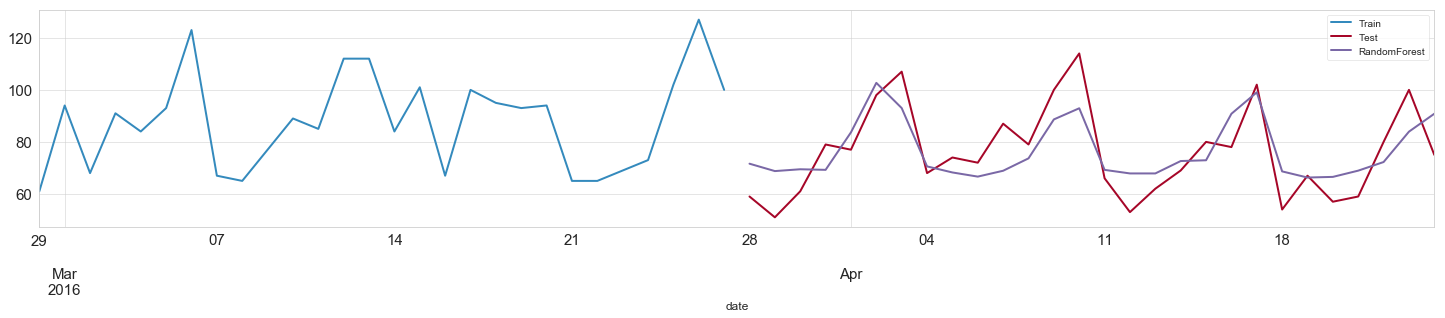

In [50]:
model_name='RandomForest'
predictions[model_name] = test_final["preds_"+model_name]

#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='date',y='demand',label='Train',ax=ax)
test_final.plot(x='date',y='demand',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test_final['demand']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t_lgb, 'RMSE':score},ignore_index=True)

Random Forest also performs well.

## Linear Regression

RMSE for LinearReg: 10.9119


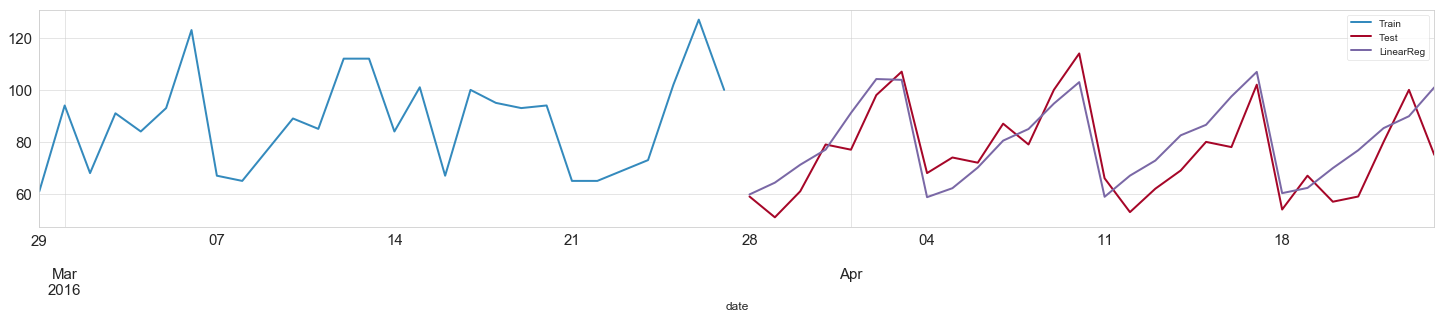

In [51]:
model_name='LinearReg'
predictions[model_name] = test_final["preds_"+model_name]

#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='date',y='demand',label='Train',ax=ax)
test_final.plot(x='date',y='demand',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test_final['demand']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t_linreg, 'RMSE':score},ignore_index=True)

Good old Linear Regression is excellent here! Better than Random Forest

In [27]:
stats.sort_values(by='RMSE')

,Model Name,Execution Time,RMSE
6,LightGB,1.650283,10.391956
8,LinearReg,0.004501,10.911912
7,RandomForest,1.650283,11.365733
5,SARIMAX,430.375012,14.368110
4,SARIMA,159.379779,14.431990
2,Triple Exponential Smoothing,37.618558,14.877146
3,ARIMA,84.188170,17.268283
1,Double Exponential Smoothing,1.923336,22.650065
0,Simple Exponential Smoothing,0.004501,25.901028


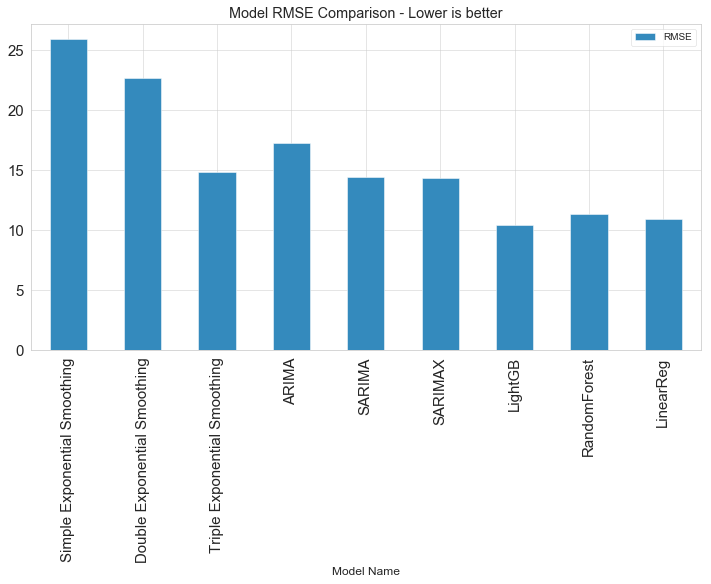

In [35]:
stats.plot(kind='bar',x='Model Name', y='RMSE', figsize=(12,6), title="Model RMSE Comparison - Lower is better");

Reaching the end of our analysis, I can say that this is just a baseline experiment. More features could of course be created followed by feature selection techniques to choose the optimum number, more hyper-parameter tuning could be done and the list can go on.

So are ML methods better than classical time series forecasting methods?

*Maybe*

It surely depends on the problem. Machine learning methods need features. If we just have the values of the time series, then the only features we can create are based on them. These would be lags, moving averages etc, so we can include as much information as possible without making too many columns. Linear regression with only 6 features outperformed all classical methods. It is to the Data Scientist's hand to make ML methods better via feature engineering. It is not necessarily the model that will highlight the algorithms, but the data that are feeding them.

So ML models with LightGB won the fight, but not the war.